In [1]:
#here we set up and run a ics diffusion simulation (similar to a spinning disk)
#in this version an analog noise model is used (as with an EMCCD)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysimfcs_utils as simutils
import analysis_utils as autils
from tqdm.notebook import tqdm
import pandas as pd
import tifffile

In [3]:
#each species is described by number of particles, diffusion coefficient, and a brightness array (length 2?)
simspecies=[{'N':2000,'D':10.0,'B':[100000.0]}]
#simspecies=[{'N':2000,'D':10.0,'B':[100000.0,100000.0]},
#           {'N':2000,'D':10.0,'B':[100000.0,0.0]}]

In [4]:
#the simulation settings are boxsize (microns), boxpixels, w0 (2 sigma psf)
#zratio (z0/w0), nframes, frametime (us), background (array of cps), dims (active dimensions)
#mode--point, raster_line, raster_image, and image
simsettings={'boxsize':3.2,'boxpixels':64,'w0':0.17,'zratio':5,'nframes':256,
             'frametime':1000.0,'background':[100.0,100.0],'dims':[True,True,True],
             'mode':'image','boundarytype':'periodic','noisemode':'analog'}
#set the analog noise settings
simutils.analoggain=20.0
simutils.analogoffset=100.0
simutils.analogreadstdev=5.0

In [5]:
ssimsettings=simutils.scaleSimSettings(simsettings)
ssimspecies=simutils.scaleSimSpecies(simsettings,simspecies)

In [6]:
ssimsettings

{'boxsize': 3.2,
 'boxpixels': 64,
 'w0': 3.4,
 'zratio': 5,
 'nframes': 256,
 'frametime': 1000.0,
 'background': [0.1, 0.1],
 'dims': [True, True, True],
 'mode': 'image',
 'boundarytype': 'periodic',
 'noisemode': 'analog'}

In [7]:
ssimspecies

[{'N': 2000, 'D': 3.999999999999999, 'B': [100.0]}]

In [8]:
simstack=simutils.runImageSimulation(ssimsettings,ssimspecies)

  0%|          | 0/256 [00:00<?, ?it/s]

In [9]:
simstack.shape

(256, 1, 64, 64)

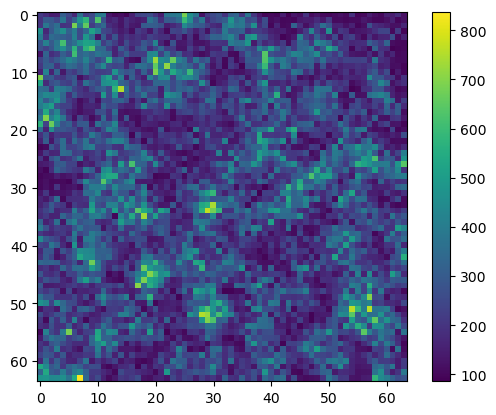

In [10]:
plt.imshow(simstack[0,0])
plt.colorbar()

In [11]:
tifffile.imwrite('analog_movie.tif',simstack.astype(float))

In [15]:
nchan=len(simspecies)
corrstack=[]
for i in range(nchan):
    corr=np.array([autils.autocorr2d(simimg) for simimg in simstack[i]]).mean(axis=0)
    corr=autils.avgquadrants(corr)
    midx,midy=corr.shape[0]//2,corr.shape[1]//2
    #set the middle pixel to the average from either side
    corr[midy,midx]=0.5*(corr[midy,midx+1]+corr[midy,midx-1])
    corrstack.append(corr)

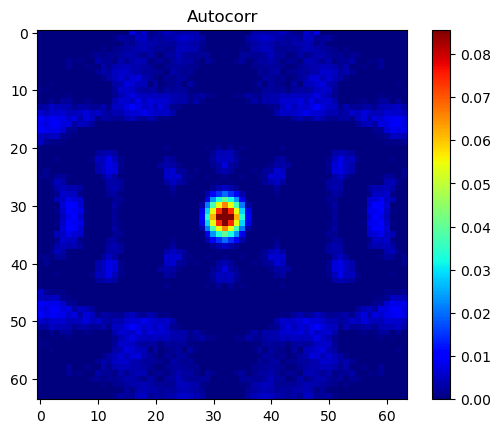

In [18]:
maxcorr=max([img.max() for img in corrstack])
plt.imshow(corrstack[0],interpolation='none',vmin=0,vmax=maxcorr,cmap='jet')
plt.title('Autocorr')
plt.colorbar()

In [19]:
tifffile.imwrite('analog_moviecorr.tif',corrstack)